In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


Bad key text.latex.unicode in file /home/mohana/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /home/mohana/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /home/mohana/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file from
https:/

In [5]:
#blob test for damaged cookie detection
def blobtest(image_fg): #takes in a clear image of a foreground; the bg should be black; to be used after grabcut 
    
    unacceptable = True #the cookie is damaged and unacceptable by default 

    #turn the image into b&w -> blur -> thresholding -> second blur
    bw_im = cv.cvtColor(image_fg, cv.COLOR_BGR2GRAY)
    blur_im = cv.GaussianBlur(bw_im,(3,3),0)
    ret,im_thresh = cv.threshold(blur_im, 20,255,cv.THRESH_BINARY)
    blurthresh_im = cv.GaussianBlur(im_thresh,(3,3),0)
    
    #invert the image
    inv = cv.bitwise_not(im_thresh)
    #resize it to make it smaller for easier blob detection
    im = cv.resize(inv, (150,150))
    
    #setting the parameters for blob detection
    params = cv.SimpleBlobDetector_Params()
    #detector = cv.SimpleBlobDetector(params)

    params.minThreshold = 0
    params.maxThreshold = 100

    #setting the circularity of the cookie
    params.filterByCircularity = True
    params.minCircularity = 0.75

    #setting the max and min area of the cookie
    params.filterByArea = True
    params.minArea = 4000
    params.maxArea = 11000

    #setting the convexivity of the cookie
    params.filterByConvexity = True
    params.minConvexity = 0.7

    #setting the elongation of the cookie
    params.filterByInertia = True
    params.minInertiaRatio = 0.1

    #finding the local version of cv2
    ver = (cv.__version__).split('.')
    if int(ver[0]) < 3 :  #if you have opencv ver2.x
        detector = cv.SimpleBlobDetector(params)
    else : 
        detector = cv.SimpleBlobDetector_create(params)   #for opencv 3.x and above
    
    #list of found blobs
    keypoints = detector.detect(im)
    
    if(len(keypoints)>0): #find the number of keypoints; if 0 then the cookie is unacceptable, o/w it is an acceptable cookie
        unacceptable=False
    
    return unacceptable

In [6]:
def cookie_broken(imgname):
    
    img = cv.imread(imgname, 1) 
    scaled_cookie = cv.resize(img, (255,255)) #scale image
    
    #using grabcut to get the mask of where the foreground is
    mask = np.zeros(scaled_cookie.shape[:2], np.uint8)

    bgmodel = np.zeros((1,65), np.float64)
    fgmodel = np.zeros((1,65), np.float64)

    #only the edges(20 px) will definitely be the background 
    rectangle = (20, 20, 224, 224) 

    cv.grabCut(scaled_cookie, mask, rectangle, bgmodel, fgmodel, 18, cv.GC_INIT_WITH_RECT)

    mask2 = np.where((mask == 2)|(mask == 0), 0, 1).astype('uint8') #the mask
    image_fg = scaled_cookie * mask2[:, :, np.newaxis] # image with only the foreground for blob test

    #TEST1--cracks test
    #removing any background noise
    kernel = np.ones((5,5))/25
    dst = cv.filter2D(mask2,-1,kernel)
    
    #searching the masks for any gaps
    i = 20     #start searching from 20th row

    broken = False  #assume it is not broken by default
    start_row = 0    #to keep track of the top edge of the cookie

    while i < 225:   #no need to search last 30 px

        left = 0
        right = 0

        for j in range(20,235):    #find the first non-zero pixel from left
            if(dst[i,j] != 0):
                left = j
                break

        for j in range(254,20,-1):    #find the last non-zero pixel
            if(dst[i,j] != 0):
                right = j
                break

        if(left != right and right-left > 5):  #to catch crumbs

            if(start_row == 0):   #reached the top edge
                start_row = i
                i += 10     #start searching after 10px b/c edges of cookie may not be perfectly curved

            else:
                for j in range(left, right):   #searching for any gaps
                    if(dst[i, j] != 1):
                        broken = True   #the cookie is broken
                        i = 225  #break from the outer while loop 

        i += 1
        
    #TEST2--blobtest
    bad_blob = blobtest(image_fg)
    
    bad_cookie = broken or bad_blob #only if both return false then the cookie is undamaged
        
    return bad_cookie

In [7]:
imgname = 'cookies/cookie0.jpg' #unbroken cookie

In [8]:
cookie_broken(imgname)

False

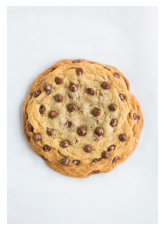

In [9]:
img = cv.imread(imgname, 1)
#here is the image we tested on.. it is indeed not broken!
plt.axis("off")
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()

In [532]:
b_cookie = 'cookies/b-cookie7.jpg'
cookie_broken(b_cookie) #a broken cookie


True

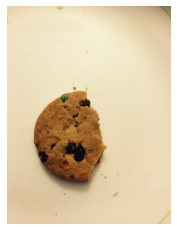

In [533]:
img2 = cv.imread(b_cookie)
#its a broken cookie!
plt.axis("off")
plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
plt.show()